# EBM Notebook

- YOUR CLASSIFIER IS SECRETLY AN ENERGY BASED MODEL AND YOU SHOULD TREAT IT LIKE ONE: https://arxiv.org/abs/1912.03263
    - s
- Benchmarking Graph Neural Networks https://arxiv.org/pdf/2003.00982.pdf
    - introduced 'graph classifier layer' that averages node-level feature representation
- Graph Neural Tangent Kernel: Fusing Graph Neural Networks with Graph Kernels https://arxiv.org/pdf/1905.13192.pdf

In [1]:
import os, collections
import numpy as np
import seaborn as sns
import networkx as nx
import pandas as pd
from scipy import spatial
import networkx as nx
from itertools import permutations   

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

torch.manual_seed(0)

## Graph Isomorphisms

In [2]:
perm = list(permutations(range(5)))[40]
perm_inv = np.arange(len(perm))[np.argsort(perm)]

perm =  [1, 3, 4, 0, 2]
perm_inv =  [3, 0, 4, 1, 2]


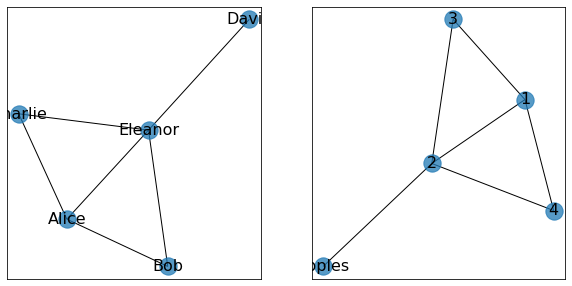

In [22]:
## simple example graph
G1 = nx.Graph()
G1_edgelist = [(0,1), (0,4), (0,2), (1,4), (2,4), (3,4)]
G1.add_edges_from(G1_edgelist)

## graph with permuted nodes
G2 = nx.Graph()
G2_edgelist = [(perm[0],perm[1]), (perm[0],perm[4]), (perm[0],perm[2]), (perm[1],perm[4]), (perm[2],perm[4]), (perm[3],perm[4])]
G2.add_edges_from(G2_edgelist)

print('perm = ', list(perm))
print('perm_inv = ', list(perm_inv))

## draw them
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(2*5,1*5))

pos=nx.spring_layout(G1)
labels={}
labels[0]='Alice'
labels[1]='Bob'
labels[2]='Charlie'
labels[3]='David'
labels[4]='Eleanor'
nx.draw_networkx_nodes(G1, pos, nodelist=[0,1,2,3,4], alpha=0.75, ax=ax1)
nx.draw_networkx_edges(G1, pos, width=1.0, ax=ax1)
nx.draw_networkx_labels(G1, pos, labels, font_size=16, ax=ax1)

pos=nx.spring_layout(G2)
labels={}
labels[0]=''
labels[1]='1'
labels[2]='2'
labels[3]='3'
labels[4]='4'
nx.draw_networkx_nodes(G2, pos, nodelist=[0,1,2,3,4], alpha=0.75, ax=ax2)
nx.draw_networkx_edges(G2, pos, width=1.0, ax=ax2)
nx.draw_networkx_labels(G2, pos, labels, font_size=16, ax=ax2)

plt.show()

The adjacency matrix transforms as

$$ A_2 = P^T A_1 P $$

In [4]:
A1 = nx.adjacency_matrix(G1, nodelist=[0,1,2,3,4]).todense()
A2 = nx.adjacency_matrix(G2, nodelist=[0,1,2,3,4]).todense()

P = np.zeros((5,5), dtype=int)
for i in range(5):
    P[i, perm[i]] = 1
    
PT = np.transpose(P)

np.dot(P, PT)

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])

In [5]:
np.dot(P, np.arange(5))

array([1, 3, 4, 0, 2])

In [6]:
A2 == np.dot(PT, np.dot(A1, P))

matrix([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]])

The degree matrix also transforms the same way

$$ D_2 = P^T D_1 P $$

In [7]:
D1 = np.eye(5)
D2 = np.eye(5)
for i in range(5):
    D1[i,i] = np.sum(A1[i,:])
    D2[i,i] = np.sum(A2[i,:])

In [8]:
D2 == np.dot(PT, np.dot(D1, P))

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

## Node Classification w/ Planetoid dataset

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
dataset.__dict__

{'name': 'Cora',
 'root': '/tmp/Cora',
 'transform': None,
 'pre_transform': None,
 'pre_filter': None,
 '__indices__': None,
 'data': Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708]),
 'slices': {'x': tensor([   0, 2708]),
  'edge_index': tensor([    0, 10556]),
  'y': tensor([   0, 2708]),
  'train_mask': tensor([   0, 2708]),
  'val_mask': tensor([   0, 2708]),
  'test_mask': tensor([   0, 2708])}}

In [10]:
print(len(dataset))
print(dataset.num_classes)
print(dataset.num_node_features)

1
7
1433


In [11]:
data.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [12]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        
        #x = x.mean()
        x = F.log_softmax(x, dim=1)
        
        return x

In [13]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()

for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    #out = F.log_softmax(model(data), dim=1)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [14]:
model.eval()
_, pred = model(data).max(dim=1)
#_, pred = F.log_softmax(model(data), dim=1).max(dim=1)
correct = float (pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.7930


In [15]:
data

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])

In [16]:
def energy(data):
    """
    I added a mean over the node index, not sure if this changes the math at all...
    """
    #return -torch.mean(torch.log(torch.sum(torch.exp(model(data)), axis=1)))
    return - torch.mean(model(data))

In [17]:
energy(data)

tensor(5.1040, grad_fn=<NegBackward>)

In [18]:
data.__dict__

{'x': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'edge_index': tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
         [ 633, 1862, 2582,  ...,  598, 1473, 2706]]),
 'edge_attr': None,
 'y': tensor([3, 4, 4,  ..., 3, 3, 3]),
 'pos': None,
 'norm': None,
 'face': None,
 'train_mask': tensor([ True,  True,  True,  ..., False, False, False]),
 'val_mask': tensor([False, False, False,  ..., False, False, False]),
 'test_mask': tensor([False, False, False,  ...,  True,  True,  True])}

## NDSSL data

In [19]:
from torch_geometric.data import Data, InMemoryDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#from imports import *

class EgoDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(EgoDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['EGO_graph_full.csv', 'EGO_graph_full_attr.csv']
    @property
    def processed_file_names(self):
        return ['EGO_graph_full.pt']

    def download(self):
        pass
    
    def process(self):
        self.le_Gender, self.le_HI, self.le_zipcode = LabelEncoder(), LabelEncoder(), LabelEncoder()
        
        self.index = pd.read_csv(self.raw_paths[0]) - 1
        self.attrs = pd.read_csv(self.raw_paths[1])
        
        data_list = []
        
        self.attrs['Gender'] = self.le_Gender.fit_transform(self.attrs.iloc[:,0])
        self.attrs['Household.Id'] = self.le_HI.fit_transform(self.attrs.iloc[:,1])
        self.attrs['zipcode'] = self.le_zipcode.fit_transform(self.attrs.iloc[:,2])
        node_features = self.attrs.values
        
        node_features = torch.FloatTensor(node_features)
        #node_features = torch.LongTensor(node_features).unsqueeze(1)
        target_nodes = self.index.iloc[:,1].values
        source_nodes = self.index.iloc[:,0].values

        edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)
        x = node_features

        # y = torch.FloatTensor([self.attrs.iloc[:,0].values])

        data = Data(x=x, edge_index=edge_index)
        data_list.append(data)
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [21]:
dataset = EgoDataset('/Users/hartnett/Desktop/DGM/data/')
dataset[0].x.shape

Processing...


<ipython-input-19-efe7cc6eece3>:38: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)


Done!


torch.Size([1601050, 3])

In [ ]:
NDSSL_edgelist.shape

In [ ]:
len(np.unique(NDSSL_edgelist))

In [ ]:
G_NDSSL = nx.read_edgelist("/Users/hartnett/Desktop/DGM/data/Network Data/NDSSL RAW/Processed Data/NDSSL.txt")
print('number of nodes = %i' % G_NDSSL.number_of_nodes())
print('number of edges = %i' % G_NDSSL.number_of_edges())

In [ ]:
[1] 1601050
> ecount(g)
[1] 17956198

In [ ]:
with open("/Users/hartnett/Desktop/DGM/data/Network Data/NDSSL RAW/Processed Data/NDSSL.txt") as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip().split(' ') for x in content] 

In [ ]:
content[0]

In [ ]:
from torch_geometric.data import Data, InMemoryDataset

class NDSSLDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(NDSSLDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
    @property
    def raw_file_names(self):
        return ['EGO_graph_second.csv', 'EGO_graph_second_attr.csv']
    @property
    def processed_file_names(self):
        return ['EGO_graph_second.pt']
    def download(self):
        pass
    
    def process(self):
        self.index = pd.read_csv(self.raw_paths[0]) - 1
        self.attrs = pd.read_csv(self.raw_paths[1])
        
        data_list = []
        
        self.attrs['Gender'] = le_Gender.fit_transform(self.attrs.iloc[:,0])
        self.attrs['Household.Id'] = le_HI.fit_transform(self.attrs.iloc[:,1])
        self.attrs['zipcode'] = le_zipcode.fit_transform(self.attrs.iloc[:,2])
        node_features = self.attrs.values
        
        node_features = torch.FloatTensor(node_features)
        #node_features = torch.LongTensor(node_features).unsqueeze(1)
        target_nodes = self.index.iloc[:,1].values
        source_nodes = self.index.iloc[:,0].values
        edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)
        x = node_features
        # y = torch.FloatTensor([self.attrs.iloc[:,0].values])
        data = Data(x=x, edge_index=edge_index)
        data_list.append(data)
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

